In [1]:
import pandas as pd
import numpy as np
from scipy import ndimage
from scipy import signal
import math
import gmaps
import geopy
import matplotlib.pyplot as plt

In [2]:
API_KEY = '<my key...'
gmaps.configure(api_key=API_KEY)
geocoder = geopy.geocoders.GoogleV3(api_key=API_KEY)

In [3]:
# may require restart after first time
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable --py --sys-prefix gmaps

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Enabling notebook extension jupyter-gmaps/extension...
      - Validating: ok


In [4]:
# Read global population density data 
data_path = 'data\gpw_v4_population_count_rev11_2020_2pt5_min.asc'

data = np.zeros([4320,8640])
with open(data_path) as f:
    for i, line in enumerate(f):
        if i>6:
            data[i-7,:] = np.array([float(num) for num in line.split()])
            

In [5]:
data.shape

(4320, 8640)

In [6]:
data[data==-9999]=np.nan

In [8]:
# Input parameters: 

distance = 2850
center = (32.05, 34.76)


In [7]:
EARTH_RADIUS = 6371
# EARTH_CIRCUMFERENCE = 40075

def coord_to_index(latitude, longitude, data_size):
    num_rows = data_size[0]
    num_cols = data_size[1]
    row_idx = int(np.mod(np.round((-latitude + 90)/180 * num_rows), num_rows))
    col_idx = int(np.mod(np.round(( longitude+180)/360 * num_cols), num_cols))
    return row_idx, col_idx

def index_to_coord(row_idx, col_idx, data_size):
    num_rows = data_size[0]
    num_cols = data_size[1]
    longitude =  col_idx/num_cols*360 - 180
    latitude  = -row_idx/num_rows*180 + 90
    return latitude, longitude

def target_coord(center_coord, angle, distance_km, sphere_radius_km=EARTH_RADIUS):
    # Source for formulas : https://www.movable-type.co.uk/scripts/latlong.html
    
    # First convert everything to radians and to shorter names
    x1 = math.radians(center_coord[0])
    y1 = math.radians(center_coord[1])
    theta = math.radians(angle)
    d = distance_km
    R = sphere_radius_km
    
    # Apply formulas
    x2 = np.arcsin(np.sin(x1)*np.cos(d/R)+np.cos(x1)*np.sin(d/R)*np.cos(theta))
    y2 = y1 + np.arctan2(np.sin(theta)*np.sin(d/R)*np.cos(x1),np.cos(d/R)-np.sin(x1)*np.sin(x2))
    
    # Convert results back to degrees and normalize
    target_latitude = np.mod(math.degrees(x2)+270,180)-90
    target_longitude = np.mod(math.degrees(y2)+540,360)-180
    return target_latitude, target_longitude


In [9]:
circumference = 2 * np.pi * distance
n_samples = int(np.max(data.shape)) 
locations = [np.nan]*(n_samples)
pop_density = np.zeros(n_samples)

for idx, angle in enumerate(np.linspace(0, 360-(360/n_samples), num=n_samples)):
    target = target_coord(center, angle, distance)
    locations[idx] = target
    row_idx, col_idx = coord_to_index(target[0],target[1], data.shape)
    pop_density[idx] = data[row_idx, col_idx]

pop_density[np.isnan(pop_density)] = 0

In [10]:
# plot on map
fig = gmaps.figure()
markers = gmaps.marker_layer([center])
fig.add_layer(markers)
heatmap_layer = gmaps.heatmap_layer(locations, weights=pop_density)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

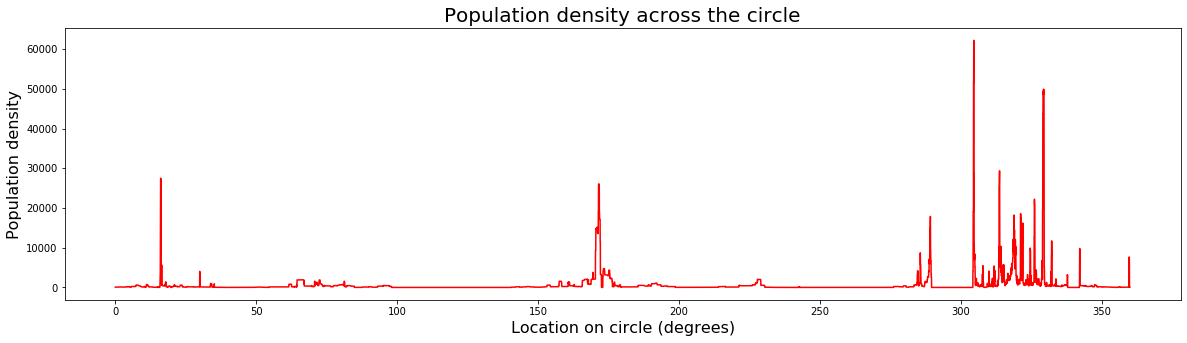

In [11]:
# Plot density signal:
# x_axis_values = np.linspace(circumference/n_samples,circumference,n_samples)
x_axis_values = np.linspace(360/n_samples,360,n_samples)

plt.figure(figsize=[20,5])
plt.plot(x_axis_values, pop_density, c='r')

plt.xlabel('Location on circle (degrees)',size=16);
plt.ylabel('Population density',size=16);
plt.title('Population density across the circle', size=20);
# plt.xlim([315,320]);

(-500, 31000)

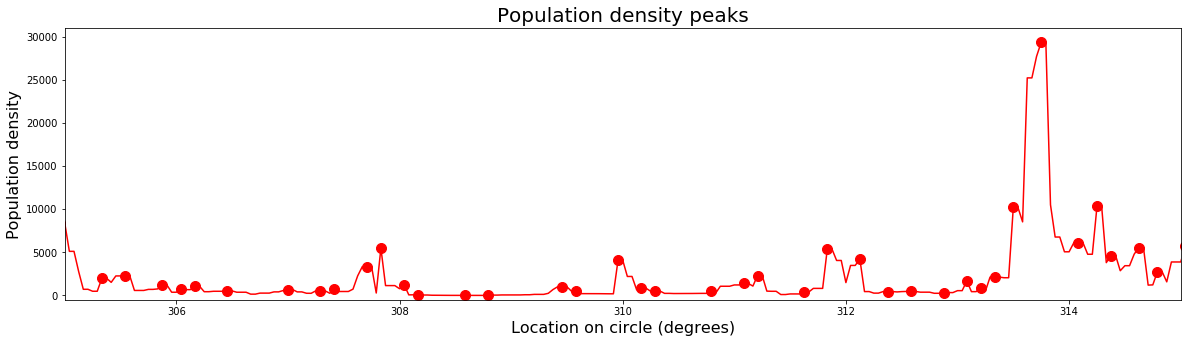

In [18]:
peak_indexes = signal.find_peaks(pop_density)[0]
peak_values = pop_density[peak_indexes]

plt.figure(figsize=[20,5])
plt.plot(x_axis_values, pop_density, c='r')

plt.scatter(x_axis_values[peak_indexes],peak_values, c='r', s=100);
plt.xlabel('Location on circle (degrees)',size=16);
plt.ylabel('Population density',size=16);
plt.title('Population density peaks', size=20);
plt.xlim([305, 315]);
plt.ylim([-500,31000])


In [13]:
filter_width_km = 5
min_height = 100

pop_density_smoothed = np.zeros(pop_density.shape)
ndimage.filters.gaussian_filter(pop_density, filter_width_km, output=pop_density_smoothed)

min_height = 100
peak_indexes_nonsmoothed = signal.find_peaks(pop_density, height = min_height)[0]
peak_values_nonsmoothed = pop_density[peak_indexes_nonsmoothed]

peak_indexes_smoothed = signal.find_peaks(pop_density_smoothed, height = min_height)[0]
peak_values_smoothed = pop_density_smoothed[peak_indexes_smoothed]

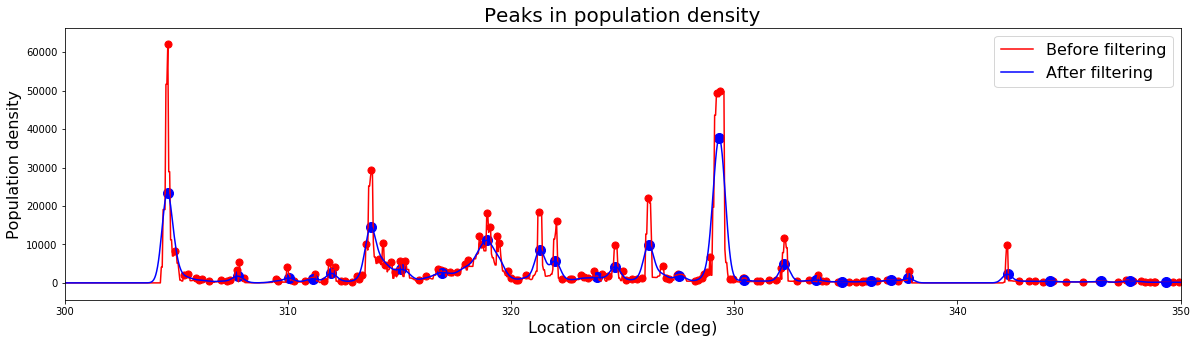

In [14]:
# Compare original to filtered signal:
plt.figure(figsize=[20,5])
plt.plot(x_axis_values, pop_density, c='r')
plt.plot(x_axis_values, pop_density_smoothed, c='b')

plt.scatter(x_axis_values[peak_indexes_nonsmoothed],peak_values_nonsmoothed, c='r', s=50);
plt.scatter(x_axis_values[peak_indexes_smoothed],peak_values_smoothed, c='b', s=100);
plt.xlabel('Location on circle (deg)',size=16);
plt.ylabel('Population density',size=16);
plt.title('Peaks in population density', size=20);
plt.legend(['Before filtering','After filtering'], fontsize=16);
plt.xlim([305, 315]);
plt.xlim([300,350]);

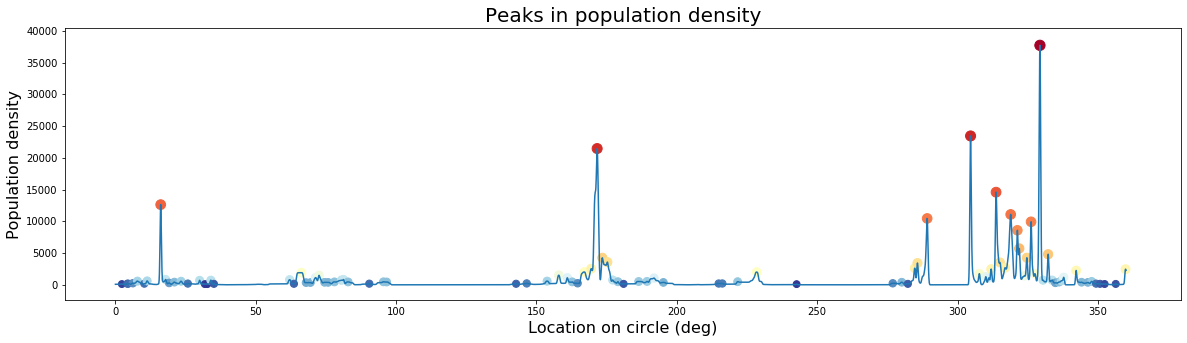

In [15]:
# Plot peaks on our circle
plt.figure(figsize=[20,5])
plt.plot(x_axis_values, pop_density_smoothed)
plt.scatter(x_axis_values[peak_indexes_smoothed],peak_values_smoothed, c=-np.log(peak_values_smoothed+1), s=10*np.log(peak_values_smoothed+1), cmap='RdYlBu');
plt.xlabel('Location on circle (deg)',size=16);
plt.ylabel('Population density',size=16);
plt.title('Peaks in population density', size=20);


In [20]:
# Create data frame for candidate locations
peak_locations = [locations[i] for i in peak_indexes_smoothed]
candidate_locations = pd.DataFrame({'pop_density' : peak_values_smoothed, 'coordinates' : peak_locations, 'country' : np.nan, 'locality' : np.nan})
# candidate_locations['country'] = np.nan
# candidate_locations['locality'] = np.nan

def get_country(Location):
    country = np.nan
    for loc_info in Location.raw.get('address_components'):
        if 'political' in loc_info.get('types'):
            country = loc_info.get('long_name')
        if 'country' in loc_info.get('types'):
            country = loc_info.get('long_name')           
    return country

def get_locality(Location):
    locality = np.nan
    for loc_info in Location.raw.get('address_components'):
        if 'locality' in loc_info.get('types'):
            locality = loc_info.get('long_name')
    return locality


for index, row in candidate_locations.iterrows():
    Location = geocoder.reverse(row.coordinates, exactly_one=True, language='en', timeout=None) # this takes some time
    candidate_locations.loc[index,'country'] = get_country(Location)
    candidate_locations.loc[index,'locality'] = get_locality(Location)

# Filter out null countries (usually in ocean)
candidate_locations.dropna(axis=0, inplace=True)

C:\Users\edden\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `timeout=None` has been passed to a geocoder call. Using default geocoder timeout. In geopy 2.0 the behavior will be different: None will mean "no timeout" instead of "default geocoder timeout". Pass geopy.geocoders.base.DEFAULT_SENTINEL instead of None to get rid of this warning.


In [21]:
candidate_locations

,pop_density,coordinates,country,locality
0,116.747969,"(57.649254679965395, 36.61238172781589)",Russia,Isayevo
4,580.648061,"(57.3158566239203, 41.027789356103995)",Russia,Babino
7,12624.179743,"(56.166307292376416, 47.220869115337564)",Russia,Cheboksary
14,113.655513,"(52.179333259475584, 56.60413093926536)",Russia,Isyangulovo
15,108.175874,"(51.88748601185881, 57.0404527082311)",Russia,Il'malya
36,579.633954,"(8.604598677229546, 45.91699640931324)",Somalia,Inadadan
62,3431.980896,"(35.27139382108663, 4.086316993304649)",Algeria,Tamsa
64,23438.915089,"(43.357510581037445, 5.431799695260793)",France,Marseille
65,1753.997263,"(44.643584065491666, 6.009975717840348)",France,Gap
66,1270.504308,"(45.57060405672462, 6.507332034702017)",France,La Léchère


In [23]:
# The probability for each country should be aggregated across all its locations, so add summed pop density for countries and localities
candidate_locations['country_total_pop_density'] = 0
candidate_locations['locality_total_pop_density'] = 0
for cname, cgroup in candidate_locations.groupby('country'):
    country_total_pop_density = cgroup.pop_density.sum()
    candidate_locations.loc[candidate_locations.country==cname,'country_total_pop_density'] = country_total_pop_density
    
    for lname, lgroup in cgroup.groupby('locality'):
        locality_total_pop_density = lgroup.pop_density.sum()
        candidate_locations.loc[np.logical_and(candidate_locations.country==cname, candidate_locations.locality==lname),'locality_total_pop_density'] = locality_total_pop_density

# We'll use this to compute the individual country probabilities:
total_pop = candidate_locations.pop_density.sum() 

# Sort by country_total_pop_density, then by locality_total_pop_density
candidate_locations.sort_values(['country_total_pop_density','locality_total_pop_density'], inplace=True, ascending=False)
candidate_locations.reset_index(inplace=True, drop=True)


In [24]:
# Finally, display results with probabilities:
for cname, cgroup in candidate_locations.groupby('country', sort=False):
    pop_within_country = cgroup.country_total_pop_density.mean()
    perc = pop_within_country/total_pop*100
    print('-'*100)
    print('(%.2f%%) ' %(perc) + (' ' if perc<10 else '') + ' Country: ' + cname)
    for lname, lgroup in cgroup.groupby('locality', sort=False):
        pop_within_locality = lgroup.locality_total_pop_density.mean()
        perc = pop_within_locality/pop_within_country*100
        print('\t\t(%.2f%%) ' %(perc) + (' ' if perc<10 else '') + ' \tLocality: ' + lname)

----------------------------------------------------------------------------------------------------
(54.08%)  Country: Germany
		(44.96%)  	Locality: Berlin
		(13.21%)  	Locality: Sachsenheim
		(11.83%)  	Locality: Halle (Saale)
		(10.24%)  	Locality: Rimpar
		(6.83%)   	Locality: Poppenhausen
		(5.08%)   	Locality: Weimar
		(3.21%)   	Locality: Aichhalden
		(2.09%)   	Locality: Coswig (Anhalt)
		(1.68%)   	Locality: Ilmenau
		(0.88%)   	Locality: Oderberg
----------------------------------------------------------------------------------------------------
(17.76%)  Country: France
		(85.10%)  	Locality: Marseille
		(6.37%)   	Locality: Gap
		(4.61%)   	Locality: La Léchère
		(3.92%)   	Locality: Sixt-Fer-à-Cheval
----------------------------------------------------------------------------------------------------
(13.26%)  Country: Switzerland
		(70.89%)  	Locality: Münchenbuchsee
		(17.09%)  	Locality: Möhlin
		(12.01%)  	Locality: Yvorne
----------------------------------------------